OBEJCT DETECTION

TABLA DE CONTENIDO

1. DESC. problema

<a name="2"></a>
## <b> <font color='red'> 2. Modules </font>  </b>

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.layers import Conv2D, Reshape

import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image



2024-03-05 20:41:06.738654: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 20:41:06.774879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 20:41:06.774911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 20:41:06.776100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 20:41:06.781730: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 20:41:06.782354: I tensorflow/core/platform/cpu_feature_guard.cc:1

<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font>  </b>

In [2]:
# plotting utilities

def plot_image_and_labels(image_path, label):
    # Cargar la imagen
    image = Image.open(image_path)
    # Crear un objeto figura y ejes
    fig, ax = plt.subplots()
    # Mostrar la imagen
    ax.imshow(image)
    # Definir las coordenadas y dimensiones de la bounding box
    x, y, w, h = label[0:4] # 
    # Crear un rectángulo que representa la bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    # Añadir el rectángulo al eje
    ax.add_patch(rect)
    # Mostrar la imagen con la bounding box
    plt.show()



# bad; falta escalar la caja acorde
def plot_image_and_label_with_prep_bad(image_path, label): 
    image = preprocess_image(image_path)
    # Crear un objeto figura y ejes
    fig, ax = plt.subplots()
    # Mostrar la imagen
    ax.imshow(image)
    # Definir las coordenadas y dimensiones de la bounding box
    x, y, w, h = label[0:4] # 
    # Crear un rectángulo que representa la bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    # Añadir el rectángulo al eje
    ax.add_patch(rect)
    # Mostrar la imagen con la bounding box
    plt.show()



    
    
# tener en cuenta que NO todas las imágenes tienen el mismo tamnaño!!!
    
def plot_image_and_label_with_prep(image_path, label, original_image_size): 
    
    image = preprocess_image(image_path)


    # Definir las coordenadas de la bounding box en la imagen original
    x_original, y_original, w_original, h_original = label[0:4] # Coordenadas y dimensiones arbitrarias

    # Calcular el factor de escala para las coordenadas
    scale_x = 224 / original_image_size[1]
    scale_y = 224 / original_image_size[0]

    # Escalar las coordenadas de la bounding box
    x_scaled = int(x_original * scale_x)
    y_scaled = int(y_original * scale_y)
    w_scaled = int(w_original * scale_x)
    h_scaled = int(h_original * scale_y)

    # Crear un objeto figura y ejes
    fig, ax = plt.subplots()

    # Mostrar la imagen
    ax.imshow(image)

    # Crear un rectángulo que representa la bounding box
    rect = patches.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled, linewidth=2, edgecolor='g', facecolor='none')

    # Añadir el rectángulo al eje
    ax.add_patch(rect)

    # Mostrar la imagen con la bounding box
    plt.show()
    

In [3]:


"""
PNG
def load_and_preprocess_image(image_path, bbox):
    # Cargar la imagen
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Decodificar la imagen en formato PNG
    image = tf.image.resize(image, [224, 224])  # Redimensionar la imagen a 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar los valores de píxeles al rango [0, 1]
    return image, bbox
"""




# Ejemplo de preprocesamiento de imágenes y etiquetas
def preprocess_image(image_path):
    # Cargar la imagen y redimensionarla
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) # resize mantiene los canales de color! 
    #  Normalizar los valores de píxeles al rango [0, 1]
    image = image / 255.0  
    return image


# Función para leer las anotaciones XML y extraer las coordenadas de las cajas delimitadoras
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extraer la etiqueta 'object' que contiene la información de la caja delimitadora
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        # Retornar las coordenadas de la caja delimitadora y la etiqueta
        return xmin, ymin, xmax, ymax, name

<a name="4"></a>
## <b> <font color='red'> 4. Loading, exploring and pre-processing data </font>  </b>

In [6]:
# Directorio de las imágenes y anotaciones
images_dir = 'data/train'
annotations_dir = 'data/train'

In [7]:
# Listas para almacenar los nombres de archivos de imágenes y las etiquetas de las cajas delimitadoras
train_images = []
train_labels = []

# Iterar sobre los archivos de anotaciones en el directorio de anotaciones
for annotation_file in os.listdir(annotations_dir):
    if annotation_file.endswith('.xml'):
        annotation_path = os.path.join(annotations_dir, annotation_file)
        image_name = annotation_file.replace('.xml', '.jpg')  # Obtener el nombre de la imagen correspondiente
        image_path = os.path.join(images_dir, image_name)

        # Leer las coordenadas de la caja delimitadora y la etiqueta
        xmin, ymin, xmax, ymax, label = parse_annotation(annotation_path)

        # Agregar la imagen y las etiquetas a las listas correspondientes
        train_images.append(image_path)
        train_labels.append([xmin, ymin, xmax, ymax, label])

# Verificar los datos obtenidos
#print("Nombres de archivos de imágenes:", train_images)
print("Etiquetas de las cajas delimitadoras:", train_labels[3],train_labels[4])

Etiquetas de las cajas delimitadoras: [1, 135, 1181, 601, 'banana'] [67, 8, 222, 155, 'apple']


In [8]:
train_images[2], train_labels[2]

('data/train/apple_42.jpg', [39, 55, 445, 474, 'apple'])

Vemos que train_images son los paths a las imágenes y que train_labels está compuesto por las coordenadas de la caja delimitadora y la clase.

### Plot image

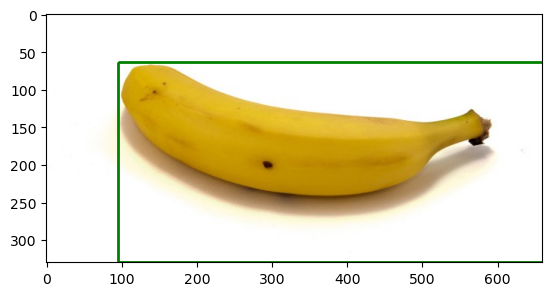

In [9]:
plot_image_and_labels(train_images[1], train_labels[1])

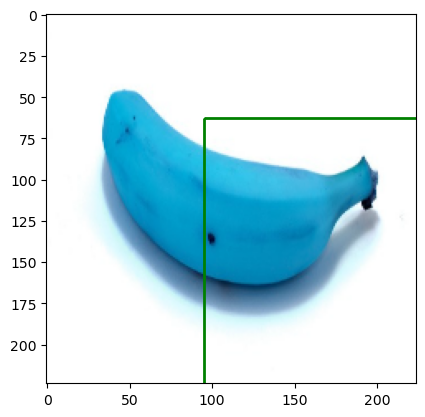

In [10]:
# veamos qué pasa si hago un pre-procesamiento de la imagen, pero
# no re-escalo apropiadamente la bounding box
plot_image_and_label_with_prep_bad(train_images[1], train_labels[1])

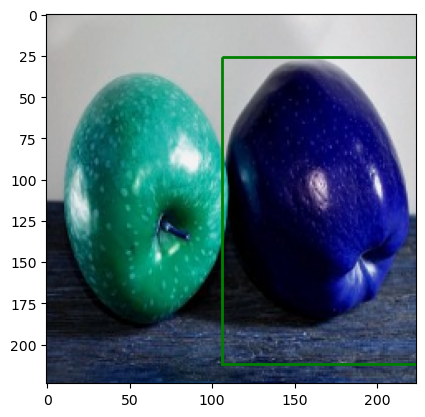

In [11]:




# Cargar la imagen y redimensionarla
image = cv2.imread(train_images[8])
resized_image = cv2.resize(image, (224, 224))  # Redimensionar a un tamaño deseado

# Escalar los valores de píxeles al rango [0, 1]
resized_image = resized_image / 255.0

# Definir las coordenadas de la bounding box en la imagen original
x_original, y_original, w_original, h_original = train_labels[8][0:4] # Coordenadas y dimensiones arbitrarias

# Calcular el factor de escala para las coordenadas
scale_x = 224 / image.shape[1]
scale_y = 224 / image.shape[0]

# Escalar las coordenadas de la bounding box
x_scaled = int(x_original * scale_x)
y_scaled = int(y_original * scale_y)
w_scaled = int(w_original * scale_x)
h_scaled = int(h_original * scale_y)

# Crear un objeto figura y ejes
fig, ax = plt.subplots()

# Mostrar la imagen
ax.imshow(resized_image)

# Crear un rectángulo que representa la bounding box
rect = patches.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled, linewidth=2, edgecolor='g', facecolor='none')

# Añadir el rectángulo al eje
ax.add_patch(rect)

# Mostrar la imagen con la bounding box
plt.show()


In [12]:
image.shape[1], resized_image.shape[1], image.shape[0]



(350, 224, 241)

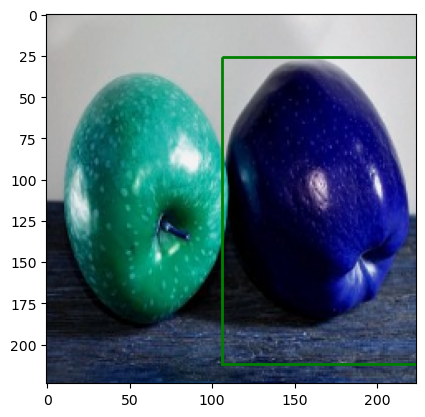

In [13]:
plot_image_and_label_with_prep(train_images[8], train_labels[8], (241, 350))

### Pre-processing

Vamos a:

- Convertir las etiquetas de clases usando one-hot encoding
- Escalar apropiadamente las etiquetas de caja delimitadora, pues están en coordenadas absolutas
y rescalamos la imagen

In [14]:
# labels
labels = []
for l in train_labels:
    labels.append({'bbox':l[0:4], 'class': l[4]})
    
# vemos un par de datos
labels[2:4]

[{'bbox': [39, 55, 445, 474], 'class': 'apple'},
 {'bbox': [1, 135, 1181, 601], 'class': 'banana'}]

Vemos que de momento las etiquetas consisten de las coordenadas de la caja delimitadora junto con la clase.

In [15]:
# debemos convertir las clases a one-hot
# Obtener todas las clases únicas
unique_classes = set(label['class'] for label in labels) # ['banana', 'apple', 'orange']

# Crear un diccionario de codificación one-hot
one_hot_encoding = {class_name: [0] * len(unique_classes) for class_name in unique_classes}
for i, class_name in enumerate(unique_classes):
    one_hot_encoding[class_name][i] = 1

# Codificar cada clase
one_hot_labels = []
for label in labels:
    class_name = label['class']
    one_hot_labels.append({
        'class': one_hot_encoding[class_name],
        'bbox': label['bbox']
    })

# Imprimir las etiquetas one-hot resultantes
for label in one_hot_labels:
    print("Clase codificada one-hot:", label['class'])
    print("Caja delimitadora:", label['bbox'])
    break

Clase codificada one-hot: [0, 1, 0]
Caja delimitadora: [304, 105, 773, 439]


In [16]:
one_hot_labels[2:4]

[{'class': [0, 1, 0], 'bbox': [39, 55, 445, 474]},
 {'class': [1, 0, 0], 'bbox': [1, 135, 1181, 601]}]

Ahora la clase está codificada como one_hot; nos falta re-escalar apropiadamenente las coordenadas de la caja delimitadora.

### Creamos el dataset

In [17]:
# pre-procesamiento de las imágenes
images = [preprocess_image(path) for path in train_images]

# Convertir las coordenadas de las cajas delimitadoras a tensores
bounding_boxes = tf.constant([obj['bbox'] for obj in one_hot_labels], dtype=tf.float32) # tf.int32; labels

# Convertir las clases a tensores
classes = tf.constant([obj['class'] for obj in one_hot_labels], dtype=tf.float32) # labels

# Crear un diccionario de tensores
dataset_labels = {'bbox': bounding_boxes, 'class': classes}

# Crear el conjunto de datos
dataset = tf.data.Dataset.from_tensor_slices((images, dataset_labels))

# Define el tamaño del batch y mezcla los datos
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE).shuffle(buffer_size=len(images))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
2024-03-05 20:42:10.708113: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289013760 exceeds 10% of free system memory.


In [18]:
for x,y in dataset:
    print(x, y)
    #print(y.shape)
    break

2024-03-05 20:42:38.098627: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289013760 exceeds 10% of free system memory.


tf.Tensor(
[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.      

<a name="5"></a>
## <b> <font color='red'> 5. Build, compile and train model </font>  </b>

In [19]:
num_classes = 3

In [20]:
# Definir la arquitectura de la CNN
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool2)
flatten = tf.keras.layers.Flatten()(conv3)
dense1 = tf.keras.layers.Dense(64, activation='relu')(flatten)
output_class = tf.keras.layers.Dense(num_classes, activation='softmax', name='class')(dense1)
output_bbox = tf.keras.layers.Dense(4, activation='linear', name='bbox')(dense1)  # 4 coordenadas para la caja delimitadora

# Construir el modelo
model = tf.keras.Model(inputs=input_layer, outputs=[output_class, output_bbox]) #, output_bbox

# Compilar el modelo con diferentes métricas y funciones de pérdida para cada salida
model.compile(optimizer='adam',
              loss={'class': 'categorical_crossentropy', 'bbox': 'mse'},
              metrics={'class': 'accuracy', 'bbox': 'mae'})

# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

In [21]:
# Entrenar el modelo
model.fit(
        dataset,   
        epochs=2)

Epoch 1/2


2024-03-05 20:42:48.623206: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100933632 exceeds 10% of free system memory.
2024-03-05 20:42:49.120744: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100933632 exceeds 10% of free system memory.


1/8 [==>...........................] - ETA: 12s - loss: 315427.2500 - class_loss: 1.1320 - bbox_loss: 315426.1250 - class_accuracy: 0.2500 - bbox_mae: 394.4687

2024-03-05 20:42:49.358752: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


8/8 [==============================] - 9s 1s/step - loss: 186028.2031 - class_loss: 152.8416 - bbox_loss: 185875.3438 - class_accuracy: 0.3833 - bbox_mae: 279.7582
Epoch 2/2
8/8 [==============================] - 8s 945ms/step - loss: 128891.3438 - class_loss: 191.8924 - bbox_loss: 128699.4609 - class_accuracy: 0.3792 - bbox_mae: 202.0131


In [ ]:
# Labels para un solo objeto (por ejemplo, un perro)
label = {
    'class': 'perro',
    'bbox': [x_min, y_min, x_max, y_max]
}



# Labels para múltiples objetos
labels = [
    {
        'class': 'perro',
        'bbox': [x_min1, y_min1, x_max1, y_max1]
    },
    {
        'class': 'gato',
        'bbox': [x_min2, y_min2, x_max2, y_max2]
    },
    # Otros objetos...
]

Cuando redimensionas una imagen y también necesitas ajustar las coordenadas de las cajas delimitadoras (bounding boxes), es importante comprender cómo afecta esto al proceso de detección de objetos. La ubicación de la caja delimitadora en relación con la imagen es crucial para la precisión de la detección. Aquí hay algunos puntos importantes a considerar:

Coordenadas Relativas vs. Absolutas:

Las coordenadas de las cajas delimitadoras pueden ser relativas o absolutas.
Las coordenadas relativas son proporcionales al tamaño de la imagen. Por ejemplo, (0.5, 0.5) significaría el centro de la imagen.
Las coordenadas absolutas son específicas del tamaño de la imagen original. Por ejemplo, (100, 100) podría ser la esquina superior izquierda de una imagen de 200x200 píxeles.
Impacto del Resize:

Si redimensionas la imagen, las coordenadas de las cajas delimitadoras también deben ajustarse en consecuencia para mantener la coherencia en la detección de objetos.
Si las coordenadas de las cajas delimitadoras están en formato relativo, no necesitas ajustarlas siempre que el método de redimensionamiento conserve las proporciones de la imagen.
Si las coordenadas son absolutas, deberás escalarlas de acuerdo con el factor de redimensionamiento aplicado a la imagen.
Métodos de Redimensionamiento:

Algunos métodos de redimensionamiento pueden conservar mejor la relación de aspecto de la imagen que otros. Es preferible utilizar métodos que preserven la relación de aspecto para evitar distorsiones.
Precaución con las Transformaciones No Lineales:

Algunas transformaciones no lineales, como la distorsión geométrica, pueden alterar significativamente las formas y proporciones de los objetos en la imagen, lo que hace que las cajas delimitadoras redimensionadas sean menos precisas.
En resumen, cuando redimensionas una imagen para el procesamiento, es fundamental ajustar adecuadamente las coordenadas de las cajas delimitadoras para mantener la precisión de la detección de objetos. Esto se logra ajustando las coordenadas de las cajas delimitadoras en proporción al cambio en las dimensiones de la imagen.